In [13]:
import tensorflow as tf
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, DepthwiseConv2D, Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
    CSVLogger
)

In [14]:
# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [15]:
path_2 = os.path.join(path, "Master Folder")

train_dir = os.path.join(path, "Master Folder", "train")
val_dir = os.path.join(path, "Master Folder", "valid")
test_dir = os.path.join(path, "Master Folder", "test")


In [16]:
img_size = 224
batch_size = 16


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True)



Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


Found 38 images belonging to 4 classes.


In [19]:
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [20]:
class DepthwiseSeparableConv(Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = DepthwiseConv2D(kernel_size=kernel_size, strides=stride, padding='same', depth_multiplier=1, use_bias=False,
             depthwise_initializer='he_normal',  
             depthwise_regularizer=tf.keras.regularizers.l2(1e-4)  )                           
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        
        self.pointwise = Conv2D(filters=out_channels, kernel_size=1, padding='same', use_bias=False,
                                kernel_initializer='he_normal',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)
                                )
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()

    def call(self, inputs, training=False):
        x = self.depthwise(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)

        x = self.pointwise(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)
        return x

In [21]:
class MobileNet_customed(tf.keras.Model):
    def __init__(self, num_classes):
        super(MobileNet_customed, self).__init__()
        
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False )      
                  
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        self.dsconv1 = DepthwiseSeparableConv(64, kernel_size=3, stride=1)
        self.dsconv2 = DepthwiseSeparableConv(128, kernel_size=3, stride=2)
        self.dsconv3 = DepthwiseSeparableConv(128, kernel_size=3, stride=1)
        self.dsconv4 = DepthwiseSeparableConv(256, kernel_size=3, stride=2)
        self.dsconv5 = DepthwiseSeparableConv(256, kernel_size=3, stride=1)
        self.dsconv6 = DepthwiseSeparableConv(512, kernel_size=3, stride=2)

        # 5 repeats of DepthwiseSeparableConv with 512 filters, stride=1
        self.dsconv_blocks = [DepthwiseSeparableConv(512, kernel_size=3, stride=1) for _ in range(5)]

        self.dsconv7 = DepthwiseSeparableConv(1024, kernel_size=3, stride=2)
        self.dsconv8 = DepthwiseSeparableConv(1024, kernel_size=3, stride=1)

        self.avg_pool = GlobalAveragePooling2D()
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)

        x = self.dsconv1(x, training=training)
        x = self.dsconv2(x, training=training)
        x = self.dsconv3(x, training=training)
        x = self.dsconv4(x, training=training)
        x = self.dsconv5(x, training=training)
        x = self.dsconv6(x, training=training)

        for dsconv in self.dsconv_blocks:
            x = dsconv(x, training=training)

        x = self.dsconv7(x, training=training)
        x = self.dsconv8(x, training=training)

        x = self.avg_pool(x)
        x = self.classifier(x)

        return x

In [22]:
model = MobileNet_customed(num_classes=4)

In [23]:
model.compile(
    optimizer=Adam(
        learning_rate=0.0001,  # Much lower learning rate
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=30,  # Increased epochs
    
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.2767 - loss: 2.6145 - val_accuracy: 0.2778 - val_loss: 2.5815
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3026 - loss: 2.5706 - val_accuracy: 0.2778 - val_loss: 2.5840
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3394 - loss: 2.5480 - val_accuracy: 0.2778 - val_loss: 2.5921
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3146 - loss: 2.5462 - val_accuracy: 0.2778 - val_loss: 2.6017
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3185 - loss: 2.5625 - val_accuracy: 0.2778 - val_loss: 2.6119
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3129 - loss: 2.5423 - val_accuracy: 0.2778 - val_loss: 2.6221
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3254 - loss: 2.5516 - val_accuracy: 0.2778 - val_loss: 2.6147
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3328 - loss: 2.5438 - val_accuracy: 0.2778 - v

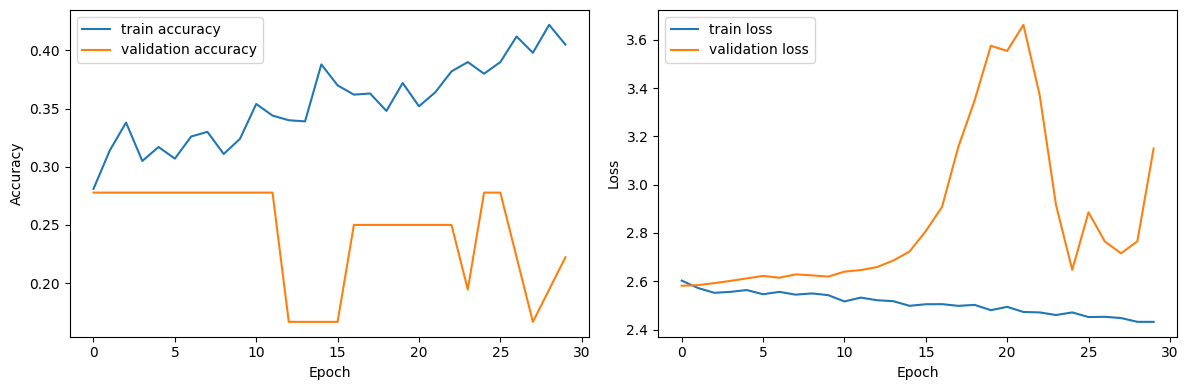

In [25]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Evaluate test accuracy
test_loss, test_acc = model.evaluate(test_generator,verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict classes on test set
test_generator.reset()
test_steps = np.ceil(test_generator.samples / batch_size)
y_pred_probs = model.predict(test_generator, steps=int(test_steps), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
# True labels
y_true = test_generator.classes[:len(y_pred)]

# Get class labels
class_labels = list(train_generator.class_indices.keys())


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.2100 - loss: 3.5073
Test Accuracy: 0.2368
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step


In [27]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.28      0.70      0.40        10
       Other       0.20      0.17      0.18         6
         Sad       0.38      0.27      0.32        11
       happy       0.00      0.00      0.00        11

    accuracy                           0.29        38
   macro avg       0.21      0.28      0.22        38
weighted avg       0.21      0.29      0.23        38



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


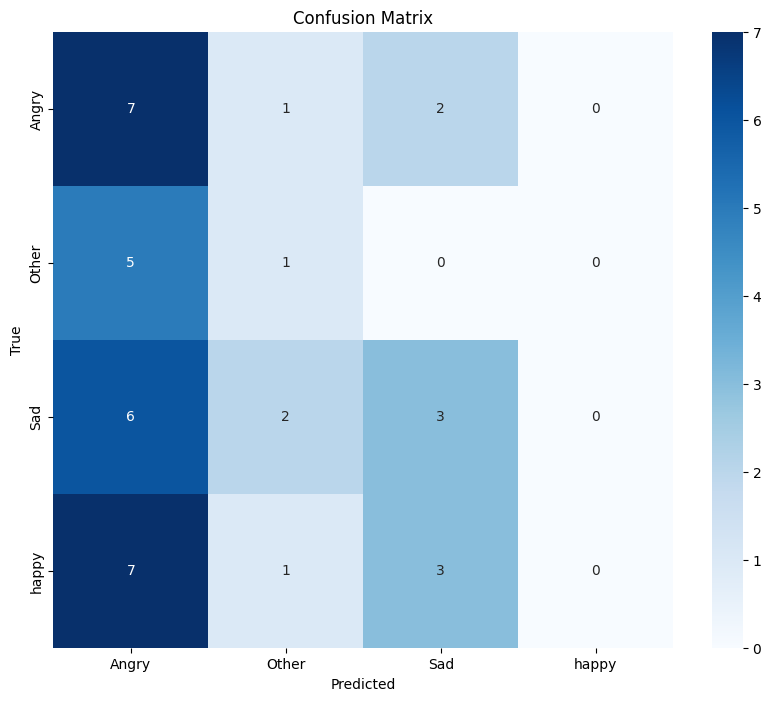

In [28]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,  
)

Epoch 1/10
32/62 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - accuracy: 0.4119 - loss: 2.4376

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4149 - loss: 2.4312 - val_accuracy: 0.2500 - val_loss: 2.7515
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3786 - loss: 2.4536 - val_accuracy: 0.3333 - val_loss: 2.6400
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4451 - loss: 2.4045 - val_accuracy: 0.2222 - val_loss: 2.9227
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4299 - loss: 2.4110 - val_accuracy: 0.2778 - val_loss: 2.9384
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4214 - loss: 2.4277 - val_accuracy: 0.2778 - val_loss: 2.6797
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4098 - loss: 2.4190 - val_accuracy: 0.2500 - val_loss: 3.0268
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4012 - loss: 2.4033 - val_accuracy: 0.1944 - val_loss: 3.4502
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.4383 - loss: 2.3795 - val_accuracy: 0.2222 - val_loss: 3.

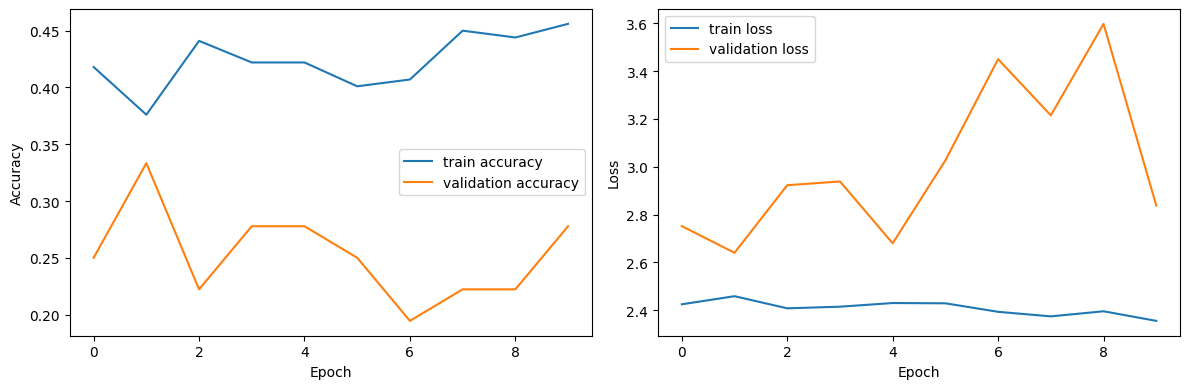

In [30]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Evaluate test accuracy
test_loss, test_acc = model.evaluate(test_generator,verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict classes on test set
test_generator.reset()
test_steps = np.ceil(test_generator.samples / batch_size)
y_pred_probs = model.predict(test_generator, steps=int(test_steps), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
# True labels
y_true = test_generator.classes[:len(y_pred)]

# Get class labels
class_labels = list(train_generator.class_indices.keys())


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.3147 - loss: 2.7563
Test Accuracy: 0.3158
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step 


In [32]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.28      0.50      0.36        10
       Other       0.33      0.33      0.33         6
         Sad       0.29      0.18      0.22        11
       happy       0.43      0.27      0.33        11

    accuracy                           0.32        38
   macro avg       0.33      0.32      0.31        38
weighted avg       0.33      0.32      0.31        38



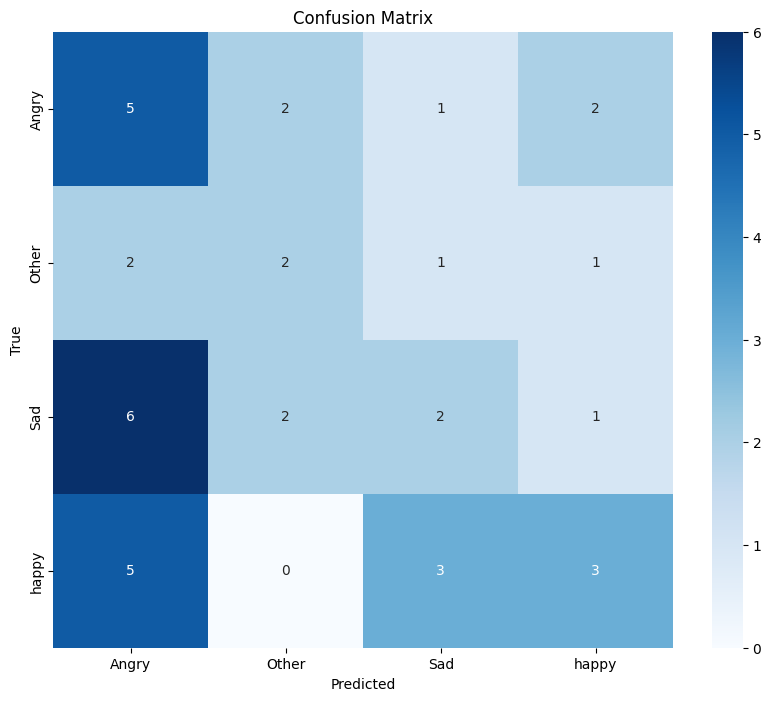

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,  
)

Epoch 1/10
32/62 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.4382 - loss: 2.3579

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4425 - loss: 2.3578 - val_accuracy: 0.2500 - val_loss: 2.9745
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4794 - loss: 2.3538 - val_accuracy: 0.2778 - val_loss: 2.9401
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4652 - loss: 2.3414 - val_accuracy: 0.2222 - val_loss: 3.8601
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4485 - loss: 2.3486 - val_accuracy: 0.2500 - val_loss: 3.0089
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4779 - loss: 2.3358 - val_accuracy: 0.3056 - val_loss: 2.8154
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4519 - loss: 2.3612 - val_accuracy: 0.3056 - val_loss: 2.8144
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4516 - loss: 2.3436 - val_accuracy: 0.3611 - val_loss: 2.9822
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4648 - loss: 2.3567 - val_accuracy: 0.2778 - val_loss: 2.

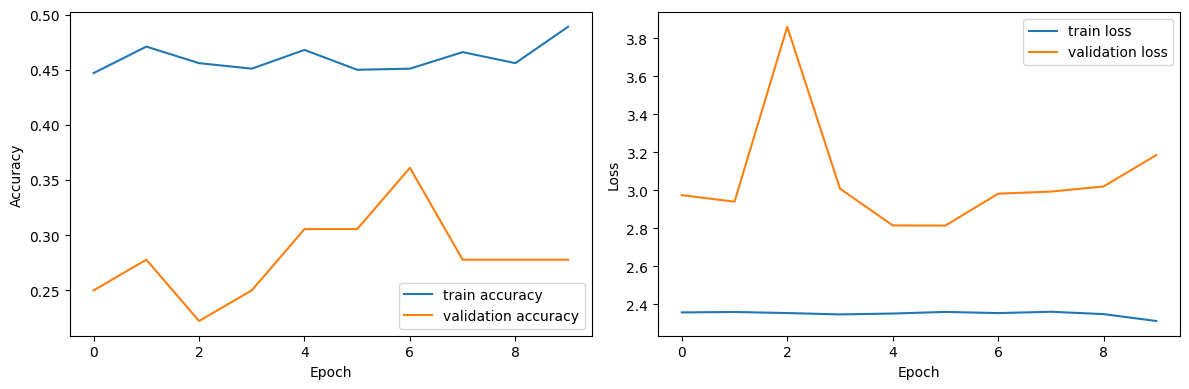

In [35]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Evaluate test accuracy
test_loss, test_acc = model.evaluate(test_generator,verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict classes on test set
test_generator.reset()
test_steps = np.ceil(test_generator.samples / batch_size)
y_pred_probs = model.predict(test_generator, steps=int(test_steps), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
# True labels
y_true = test_generator.classes[:len(y_pred)]

# Get class labels
class_labels = list(train_generator.class_indices.keys())


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3427 - loss: 3.4970
Test Accuracy: 0.3421
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step 


In [37]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.36      0.50      0.42        10
       Other       0.07      0.17      0.10         6
         Sad       0.57      0.36      0.44        11
       happy       0.67      0.18      0.29        11

    accuracy                           0.32        38
   macro avg       0.42      0.30      0.31        38
weighted avg       0.46      0.32      0.34        38



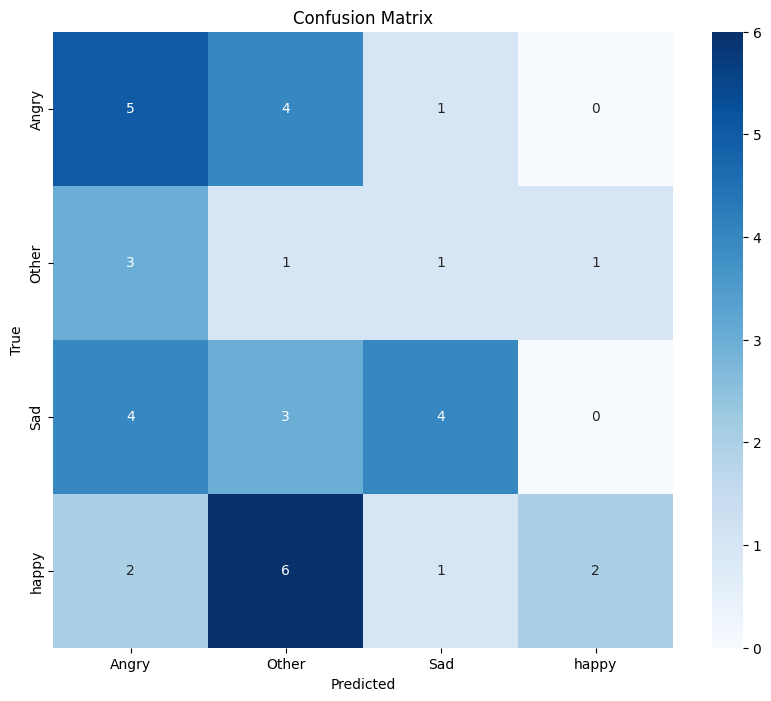

In [38]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()